# Movie Success Predictor

## 1. Installing & Importing Required Libraries

### 1.1. Installing required libraries

```pip install numpy``` <br>
```pip install pandas``` <br>
```pip install seaborn``` <br>
```pip install matplotlib``` <br>

```pip install kagglehub``` <br>
```pip install kagglehub[pandas-datasets]```

### 1.2. Importing required libraries

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsRegressor

In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

## 2. Loading the dataset

In [4]:
file_path_credits = "tmdb_5000_credits.csv"
file_path_movies = "tmdb_5000_movies.csv"

### 2.1. Loading the Dataset with KaggleHub

In [7]:
df_credits = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "tmdb/tmdb-movie-metadata",
  file_path_credits,
  pandas_kwargs={"encoding": "ISO-8859-1", "engine": "python", "on_bad_lines": "skip"},
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

df_movies = kagglehub.dataset_load(
  KaggleDatasetAdapter.PANDAS,
  "tmdb/tmdb-movie-metadata",
  file_path_movies,
  pandas_kwargs={"encoding": "ISO-8859-1", "engine": "python", "on_bad_lines": "skip"},
  # Provide any additional arguments like 
  # sql_query or pandas_kwargs. See the 
  # documenation for more information:
  # https://github.com/Kaggle/kagglehub/blob/main/README.md#kaggledatasetadapterpandas
)

### 2.2. Loading the CSV Locally

If the KaggleHub import doesn't work, we can also import the dataset from a local CSV file.

In [17]:
df_credits = pd.read_csv(f"./data/{file_path_credits}")
df_movies = pd.read_csv(f"./data/{file_path_movies}")

## 3. Cleaning the data

### 3.1. Merging the two datasets

In [8]:
df_credits.rename(columns={"movie_id": "id"}, inplace=True)

In [ ]:
df = df_movies.merge(df_credits, on='id')

### 3.2. Remove the unnecessary columns

In [20]:
df = df.drop('homepage', axis=1)
df = df.drop('original_title', axis=1)
df = df.drop('overview', axis=1)
df = df.drop('tagline', axis=1)
df = df.drop('status', axis=1)
df = df.drop('title_x', axis=1)
df = df.drop('title_y', axis=1)
df = df.drop('spoken_languages', axis=1)
df = df.drop('production_countries', axis=1)
df = df.drop('production_companies', axis=1)
df = df.drop('crew', axis=1)
df = df.drop('keywords', axis=1)
df = df.drop('id', axis=1)

> It would be great to be able to analyse the cast and its popularity, but for symplicity's sake, we'll unfortunately just drop it

In [21]:
df = df.drop('cast', axis = 1)

### 3.3. Remove missing values

> I would normally remplace the datas in the columns **budget** and **revenue**, but there are to many missing datas to extrapolate from the rest of the dataset

In [22]:
df = df.drop(df[df['genres'] == '[]'].index)
df = df.drop(df[df['budget'] == 0].index)
df = df.drop(df[df['revenue'] == 0].index)
df = df.drop(df[df['runtime'].isnull()].index)
df = df.drop(df[df['release_date'].isnull()].index)

### 3.4. Convert Strings to numerical format

#### 3.4.1. Map movie languages to a language_id

In [ ]:
print(df['original_language'].unique())

In [23]:
languages_dict = {}
language_id = 0
for lang in df['original_language'].unique():
    languages_dict[lang] = language_id
    language_id += 1
df['original_language'] = df['original_language'].map(languages_dict)

#### 3.4.2. Decomposing the release date

In [24]:
df["year"] = [None] * len(df)
df["month"] = [None] * len(df)
df["day"] = [None] * len(df)
date_order = ["year", "month", "day"]

for col, row in df.iterrows():
    date_parts = row.release_date.split("-")
    for i in range(len(date_order)):
        df.loc[col, date_order[i]] = date_parts[i]

df = df.drop("release_date", axis=1)

#### 3.4.3 Separate each genre and actors into a colummn

##### 3.4.3.1 Convert genres json format to a list

In [25]:
def extract_genres(json_str):
    try:
        items = json.loads(json_str.replace("'", '"'))
        return [g["name"] for g in items]
    except:
        return []
    
df["genres"] = df["genres"].apply(extract_genres)

##### 3.4.3.2 Create a column for each genre

In [26]:
genres_set = set()
for film_genres in df["genres"]:
    for elem in film_genres:
        genres_set.add(f"genre_{elem.lower()}")

In [27]:
genre_order = []
for genre in genres_set:
    df[genre] = 0 * len(df)
    genre_order.append(genre)

for col, row in df.iterrows():
    for i in range(len(genre_order)):
        if genre_order[i][6:].replace('_', ' ').title() in row.genres:
            df.loc[col, genre_order[i]] = 1

df = df.drop("genres", axis=1)

## 4. Predictions

### 4.1. Prediction of the budget of a movie *(regression)*

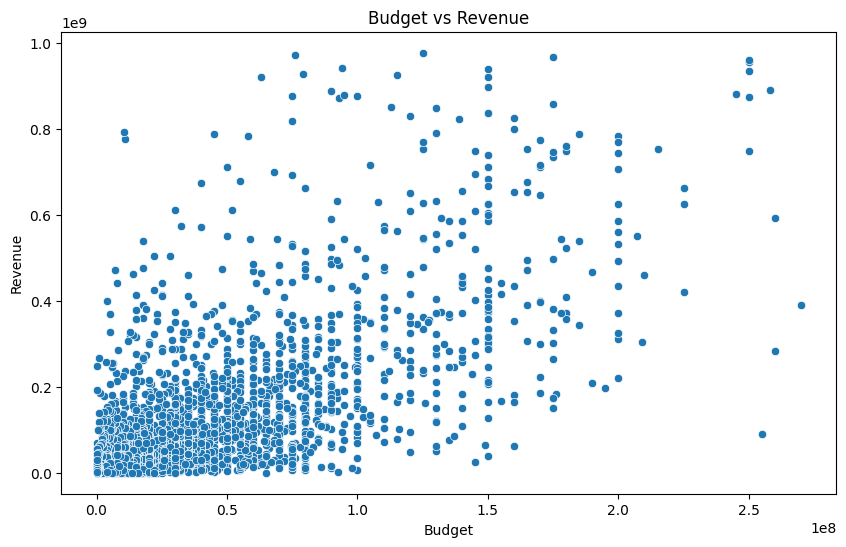

In [30]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='budget', y='revenue')
plt.title('Budget vs Revenue')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.show()

In [29]:
# remove outliers
df = df[df['budget'] < 300000000]
df = df[df['revenue'] < 1000000000]

In [31]:
X = df.drop('revenue', axis=1)
y = df['revenue']
X_scaled = StandardScaler().fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
pd.set_option('display.max_columns', None)
df.columns

Text(0, 0.5, 'Error Rate')

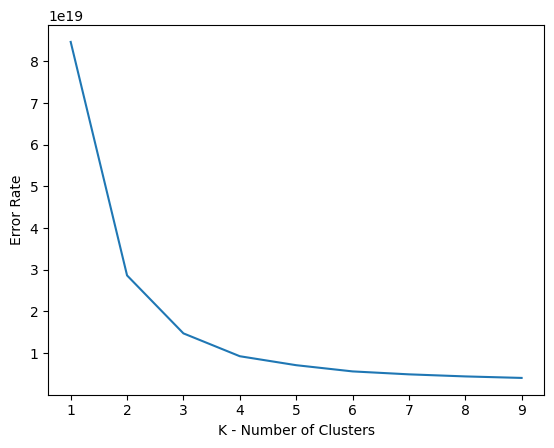

In [33]:
error = []
k_range = range(1,10) # We arbitrarily pick 10 as max as it is less than likely that we will choose more than 10 clusters
for K in k_range :
    km = KMeans(n_clusters=K)
    km.fit(df[['budget', 'original_language', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count', 'year', 'month', 'day', 'genre_family', 'genre_music', 'genre_science fiction', 'genre_thriller', 'genre_war', 'genre_comedy', 'genre_drama', 'genre_history', 'genre_foreign', 'genre_documentary', 'genre_adventure', 'genre_mystery', 'genre_fantasy', 'genre_horror', 'genre_romance', 'genre_animation', 'genre_western', 'genre_crime', 'genre_action']])
    error.append(km.inertia_) # = error rate

plt.plot(k_range,error)
plt.xlabel('K - Number of Clusters')
plt.ylabel('Error Rate')

In [34]:

knn = KNeighborsRegressor(n_neighbors=3)
knn.fit(X_train, y_train)

,n_neighbors,3
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [35]:
y_pred_answers = knn.predict(X_test)
y_pred_answers

array([1.46602300e+08, 3.46785370e+07, 4.61174770e+07, 2.24655710e+07,
       1.57876163e+07, 2.75161578e+08, 1.31238000e+08, 8.02638897e+07,
       1.25315023e+08, 5.93849298e+08, 2.42446468e+08, 4.44903697e+07,
       6.57256325e+08, 9.93743693e+07, 1.38108322e+08, 8.62194753e+07,
       5.44126027e+07, 2.99886547e+07, 1.02770385e+08, 4.21622722e+08,
       3.29946197e+07, 1.22370993e+08, 3.30054737e+07, 1.17937217e+07,
       2.65283454e+08, 3.41144210e+07, 4.26353430e+07, 1.12100595e+08,
       5.38123877e+07, 4.08376791e+08, 4.45266667e+06, 3.07151942e+08,
       6.54351100e+06, 8.54138024e+08, 1.00352383e+07, 7.21426753e+07,
       1.11517231e+08, 2.30392311e+08, 1.45701334e+08, 3.01536364e+08,
       1.34926412e+08, 3.22856890e+07, 1.54671009e+08, 1.79315187e+07,
       2.84379610e+07, 3.40976223e+07, 1.55266326e+08, 1.85244720e+07,
       8.56840323e+07, 4.68632583e+07, 4.56637723e+07, 2.62731515e+08,
       1.38829397e+08, 9.52526823e+07, 3.94746370e+07, 1.63243617e+08,
      

In [36]:
from sklearn.metrics import r2_score
accuracy = r2_score(y_test, y_pred_answers)
print("The accuracy of the model is: ", accuracy)
print("The accuracy of the model is: ", round(accuracy*100, 2), "%")

The accuracy of the model is:  0.6970931046950697
The accuracy of the model is:  69.71 %


In [37]:
df.to_csv("./data/clean_data.csv", index=False)